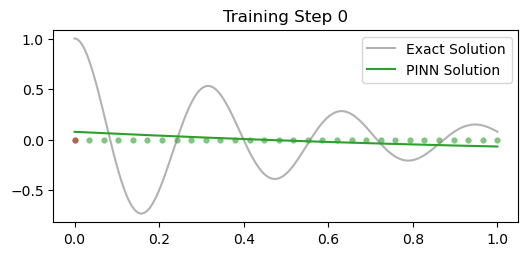

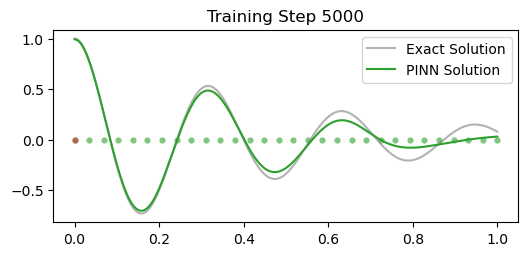

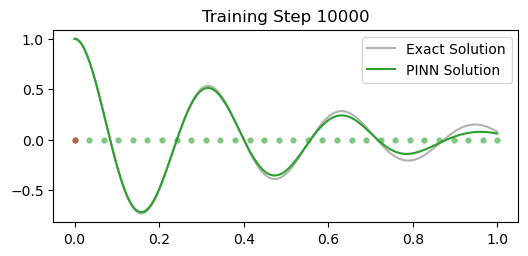

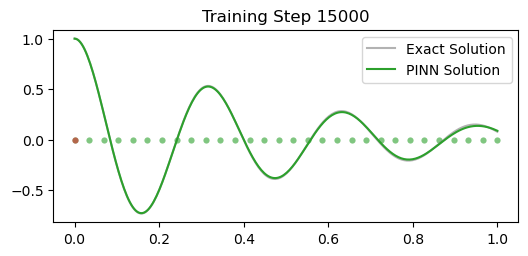

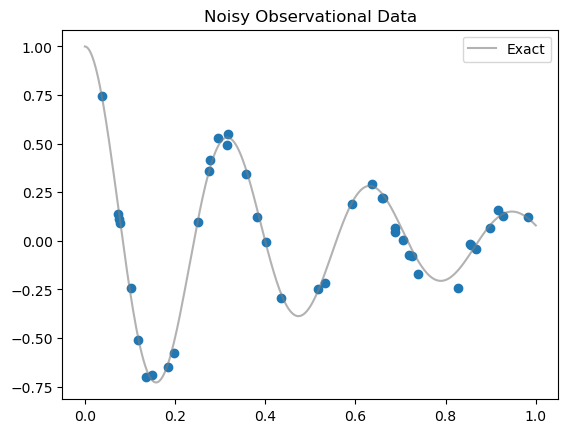

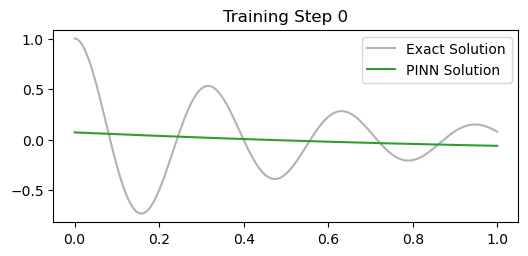

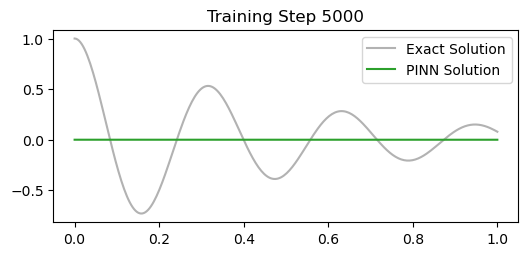

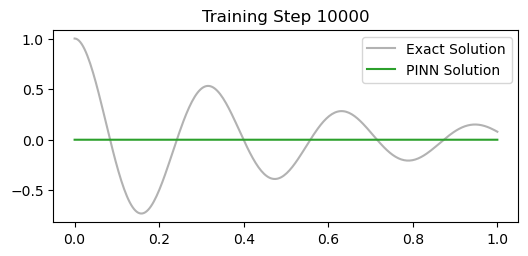

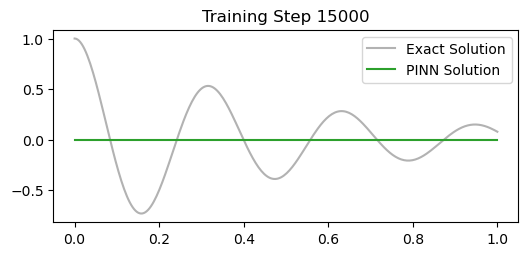

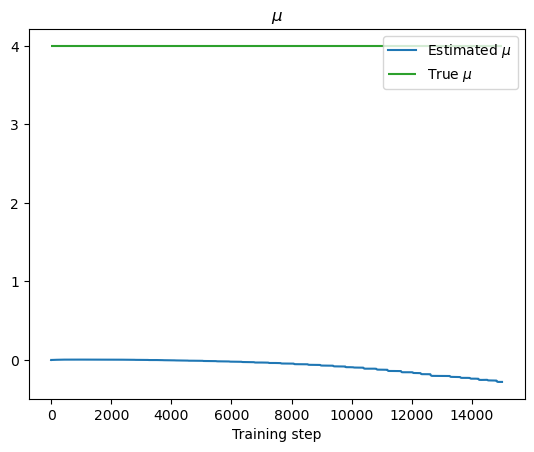

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution analytically for the given problem
def exact_solution(d, w0, t):
    assert d < w0, "damping factor must be less than the natural frequency"
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

# Fully Connected Neural Network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Parameters
torch.manual_seed(123)
d, w0 = 2, 20
mu_true, k = 2 * d, w0 ** 2
lambda1, lambda2 = 1e-1, 1e-4

# Instantiate the model
pinn = FCN(1, 1, 32, 3)

# Boundary and physics points
t_boundary = torch.tensor([[0.]], requires_grad=True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

# Optimizer
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Training Loop
for i in range(15001):
    optimiser.zero_grad()
    
    # Compute boundary loss
    u_boundary = pinn(t_boundary)
    loss1 = (torch.squeeze(u_boundary) - 1) ** 2

    dudt_boundary = torch.autograd.grad(u_boundary, t_boundary, torch.ones_like(u_boundary), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt_boundary) - 0) ** 2

    # Compute physics loss
    u_physics = pinn(t_physics)
    dudt_physics = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0]
    d2udt2_physics = torch.autograd.grad(dudt_physics, t_physics, torch.ones_like(dudt_physics), create_graph=True)[0]
    loss3 = torch.mean((d2udt2_physics + mu_true * dudt_physics + k * u_physics) ** 2)

    # Combined loss
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    loss.backward()
    optimiser.step()
    
    if i % 5000 == 0:
        u_pred = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach()[:,0], torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", color="tab:gray", alpha=0.6)
        plt.plot(t_test[:,0], u_pred[:,0], label="PINN Solution", color="tab:green")
        plt.title(f"Training Step {i}")
        plt.legend()
        plt.show()

# Noisy Data Generation
torch.manual_seed(123)
t_obs = torch.rand(40).view(-1, 1)
u_obs = exact_solution(d, w0, t_obs) + 0.04 * torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy Observational Data")
plt.scatter(t_obs[:, 0], u_obs[:, 0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact", color="tab:grey", alpha=0.6)
plt.legend()
plt.show()

# Retrain with learnable mu
torch.manual_seed(123)
pinn = FCN(1, 1, 32, 3)
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)
mus = []

for i in range(15001):
    optimiser.zero_grad()

    # Physics loss
    u_physics = pinn(t_physics)
    dudt_physics = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0]
    d2udt2_physics = torch.autograd.grad(dudt_physics, t_physics, torch.ones_like(dudt_physics), create_graph=True)[0]
    loss3 = torch.mean((d2udt2_physics + mu * dudt_physics + k * u_physics) ** 2)

    # Data loss
    u_obs_pred = pinn(t_obs)
    loss2 = torch.mean((u_obs_pred - u_obs) ** 2)

    # Combined loss
    loss = loss3 + lambda1 * loss2
    loss.backward()
    optimiser.step()
    mus.append(mu.item())

    if i % 5000 == 0:
        u_pred = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", color="tab:gray", alpha=0.6)
        plt.plot(t_test[:,0], u_pred[:,0], label="PINN Solution", color="tab:green")
        plt.title(f"Training Step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="Estimated $\mu$")
plt.hlines(2 * d, 0, len(mus), label="True $\mu$", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()
